# HDA - Project 3: TASK A
## Classification of Modes of Locomotion
This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6];
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

In [1]:
import utils
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import Conv1D, Conv2D, BatchNormalization, Dropout, LeakyReLU, Flatten, Activation, Dense, MaxPooling1D, MaxPooling2D, LSTM
from keras.models import Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# parameters definition

subject = 1
folder = "./data/full/"
label_col = 0     # default for task A
window_size = 50
stride = 50

# Section 1 - Loading and Preprocessing

### Dataset Loading 

In [3]:
# import all sessions for a subject
(data1, data2, data3, data4, data5, data6) = utils.loadData(subject, folder=folder)

# create training set and test set
X_train = np.concatenate((data1['features_interp'],\
                          data2['features_interp'],\
                          data3['features_interp'],\
                          data6['features_interp']), axis=0)

Y_train = np.concatenate((data1['labels_cut'][:,label_col],\
                          data2['labels_cut'][:,label_col],\
                          data3['labels_cut'][:,label_col],\
                          data6['labels_cut'][:,label_col]), axis=0)

X_test = np.concatenate((data4['features_interp'],\
                         data5['features_interp']), axis=0)

Y_test = np.concatenate((data4['labels_cut'][:,label_col],\
                         data5['labels_cut'][:,label_col]))

features = X_test.shape[1]
print("\nTraining samples: ", X_train.shape[0],\
      "\nTest samples:      ", X_test.shape[0],\
      "\nFeatures:            ", features)


Session shapes:
ADL1:   (45810, 110)
ADL2:   (28996, 110)
ADL3:   (30167, 110)
ADL4:   (30228, 110)
ADL5:   (27308, 110)
Drill:  (52152, 110)

Training samples:  157125 
Test samples:       57536 
Features:             110


### Dataset preparation in order to feed it to the network

In [4]:
# decision to overcome the problem of entire missing columns
X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)

# features normalization
scaler = StandardScaler().fit(X_train)
X_train =scaler.transform(X_train)
X_test = scaler.transform(X_test)

# switch to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse=False)
Y_train_oh = onehot_encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test_oh = onehot_encoder.fit_transform(Y_test.reshape(-1, 1))
print("\nClasses in training set: ", Y_train_oh.shape[1],\
      "\nClasses in test set:     ", Y_test_oh.shape[1])

print("Training set:")
X_train_s, Y_train_s = utils.prepareData(X_train, Y_train_oh, window_size, stride, shuffle=False)
print("\nTest set:")
X_test_s, Y_test_s = utils.prepareData(X_test, Y_test_oh, window_size, stride, shuffle=False)
# add bars plot


Classes in training set:  5 
Classes in test set:      5
Training set:
<class 'numpy.ndarray'> (3141, 50, 110) <class 'numpy.ndarray'> (3141, 5)

Features have shape:  (3141, 50, 110) 
Labels have shape:    (3141, 5) 
Fraction of labels:   [0.10983763 0.4237504  0.27029608 0.17191977 0.02419612]

Test set:
<class 'numpy.ndarray'> (1149, 50, 110) <class 'numpy.ndarray'> (1149, 5)

Features have shape:  (1149, 50, 110) 
Labels have shape:    (1149, 5) 
Fraction of labels:   [0.17928634 0.34290688 0.20104439 0.23846823 0.03829417]


# Section 2 - Classification with Conv1D

### Creation of one-dimensional convolutional neural network

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 18)            9918      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 18)            72        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 18)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 18)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 25, 36)            4572      
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 36)            144       
___________________________________________________________

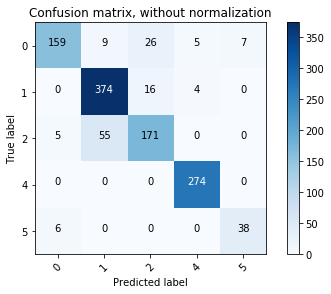

In [5]:
classes = np.max((Y_train_s.shape[1], Y_test_s.shape[1]))

model_unidim = utils.Model1D((window_size, features), classes)

opt = Adam(lr=0.01)
model_unidim.compile(optimizer = opt, loss = "categorical_crossentropy", metrics = ["accuracy"])

model_unidim.fit(x = X_train_s, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test_s, Y_test_s))

# Classification and evaluation of performances

# predict labels
Y_pred_s = model_unidim.predict(X_test_s)

# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')

# Section 3 - Classification with Conv2D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 17, 18)         49518     
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 17, 18)         72        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1, 17, 18)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 9, 18)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 3, 36)          16236     
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 3, 36)          144       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 1, 3, 36)          0         
__________

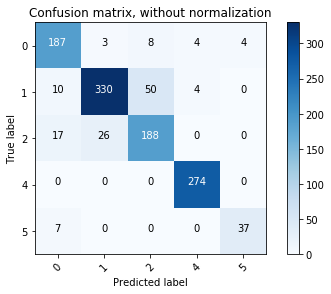

In [6]:
model_new2D = utils.Model2D((1,window_size,features), classes)
opt4 = Adam(lr=0.01)
model_new2D.compile(optimizer = opt4, loss = "categorical_crossentropy", metrics = ["accuracy"])

# need to reshape in order to fit to the new 2D model
X_train = X_train_s.reshape(X_train_s.shape[0], 1, window_size, features)
X_test = X_test_s.reshape(X_test_s.shape[0], 1, window_size, features)

model_new2D.fit(x = X_train, y = Y_train_s, epochs = 10, batch_size = 128, validation_data=(X_test, Y_test_s))

### Classification and evaluation of performances

# predict labels
Y_pred_s = model_new2D.predict(X_test)

# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, classes))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')

# Test with Deep CNN and LSTM

In [11]:
def ModelDeep(input_shape, classes):
    """ 
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns: 
    model -- a Model() instance in Keras
    """
    
    model = Sequential()
    model.add(Conv2D(filters = 18,
                    kernel_size=(5,5),
                    strides=(1,1),
                    padding='same',
                    data_format = 'channels_first',
                    input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2,2),
                          strides=2,
                          padding='same'))
    
    model.add(Dropout(0.1))
    
    model.add(Conv2D(filters = 36,
                    kernel_size=(5,5),
                    strides=(1,3),
                    data_format = 'channels_first',
                    padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2,2),
                          strides=2,
                          padding='same'))
    
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters = 72,
              kernel_size=(5,5),
              strides=(1,3),
              data_format = 'channels_first',
              padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.3))
    model.add(MaxPooling2D(pool_size=(2,2),
                          strides=2,
                          padding='same'))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    #model.add(LSTM(64, activation='tanh', recurrent_activation='hard_sigmoid', use_bias=True))
    
    model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01)))
    
    model.add(LeakyReLU(alpha=0.3))

    model.add(Dense(classes))
    model.add(Activation('softmax'))
    
    model.summary()
    
    return model

In [12]:
model_temp = ModelDeep((1,window_size,features), 5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 18, 50, 110)       468       
_________________________________________________________________
batch_normalization_10 (Batc (None, 18, 50, 110)       440       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 18, 50, 110)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 25, 110)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 9, 25, 110)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 36, 25, 37)        8136      
_________________________________________________________________
batch_normalization_11 (Batc (None, 36, 25, 37)        148       
__________

In [13]:
opt4 = Adam(lr=0.01)
model_temp.compile(optimizer = opt4, loss = "categorical_crossentropy", metrics = ["accuracy"])

# need to reshape in order to fit to the new 2D model
X_train = X_train_s.reshape(X_train_s.shape[0], 1, window_size, features)
X_test = X_test_s.reshape(X_test_s.shape[0], 1, window_size, features)

In [ ]:
model_temp.fit(x = X_train, y = Y_train_s, epochs = 15, batch_size = 128, validation_data=(X_test, Y_test_s))

Train on 3141 samples, validate on 1149 samples
Epoch 1/15
2560/3141 [=======================>......] - ETA: 25s - loss: 9.4362 - acc: 0.4988

F1-measure:  0.8529180840387727
AUC w.r. to each class:  {0: 0.9728196522150954, 1: 0.9725484922849363, 2: 0.9565779173622311, 3: 0.9908154327424401, 4: 0.8632455779514603}


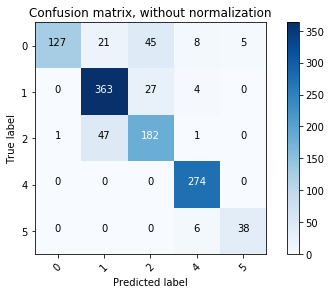

In [37]:
Y_pred_s = model_temp.predict(X_test)

# print results
#reverse the one-ot encoder procedure
Y_test_hard = np.argmax(Y_test_s, axis=1)
Y_pred_hard = np.argmax(Y_pred_s, axis=1)

print("F1-measure: ", utils.f1_score(Y_test_hard, Y_pred_hard, average='weighted'))
print("AUC w.r. to each class: ", utils.AUC(Y_test_s, Y_pred_s, 5))

# Compute and plot confusion matrix
cnf_matrix = utils.confusion_matrix(Y_test_hard, Y_pred_hard)
np.set_printoptions(precision=2)

plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1,2,4,5],
                      title='Confusion matrix, without normalization')